## Importing the datasets

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:

hdb_df = pd.read_csv("/content/drive/MyDrive/DPV_Project/Datasets/hdb.csv")
mrt_df = pd.read_csv("/content/drive/MyDrive/DPV_Project/Datasets/mrt.csv")
poi_df = pd.read_csv("/content/drive/MyDrive/DPV_Project/Datasets/poi.csv")
ridership_df = pd.read_csv("/content/drive/MyDrive/DPV_Project/Datasets/public_transport_ridership_2019_2024.csv")
pop_df = pd.read_csv("/content/drive/MyDrive/DPV_Project/Datasets/2024_population.csv")

# EGT204 Project - Data Preparation & Integration

## Dataset Overview

In [4]:
# Show dataset names and their dimensions for the markdown title
datasets_info = pd.DataFrame({
    "Dataset": [
       # "bus_line.csv",
        "hdb.csv",
        "mrt.csv",
        "poi_2022.csv",
        "public_transport_ridership_2019_2024.csv",
        "respopagesexfa2024.csv"
    ],
    "Rows": [
       # bus_df.shape[0],
        hdb_df.shape[0],
        mrt_df.shape[0],
        poi_df.shape[0],
        ridership_df.shape[0],
        pop_df.shape[0]
    ],
    "Columns": [
       # bus_df.shape[1],
        hdb_df.shape[1],
        mrt_df.shape[1],
        poi_df.shape[1],
        ridership_df.shape[1],
        pop_df.shape[1]
    ]
})

datasets_info

,Dataset,Rows,Columns
0,hdb.csv,12442,37
1,mrt.csv,247,14
2,poi_2022.csv,8672,125
3,public_transport_ridership_2019_2024.csv,72,4
4,respopagesexfa2024.csv,75696,7


## Inspect the HDB and MRT datasets

In [5]:
hdb_cols = hdb_df.columns.tolist()
mrt_cols = mrt_df.columns.tolist()

# Preview first few rows of each to confirm coordinate columns
hdb_preview = hdb_df.head(3)
mrt_preview = mrt_df.head(3)

hdb_cols, mrt_cols, hdb_preview, mrt_preview

(['Unnamed: 0',
  'blk_no',
  'street',
  'max_floor_lvl',
  'year_completed',
  'residential',
  'commercial',
  'market_hawker',
  'miscellaneous',
  'multistorey_carpark',
  'precinct_pavilion',
  'bldg_contract_town',
  'total_dwelling_units',
  '1room_sold',
  '2room_sold',
  '3room_sold',
  '4room_sold',
  '5room_sold',
  'exec_sold',
  'multigen_sold',
  'studio_apartment_sold',
  '1room_rental',
  '2room_rental',
  '3room_rental',
  'other_room_rental',
  'lat',
  'lng',
  'building',
  'addr',
  'postal',
  'SUBZONE_NO',
  'SUBZONE_N',
  'SUBZONE_C',
  'PLN_AREA_N',
  'PLN_AREA_C',
  'REGION_N',
  'REGION_C'],
 ['Unnamed: 0',
  'name',
  'stop_id',
  'line',
  'no',
  'lng',
  'lat',
  'SUBZONE_NO',
  'SUBZONE_N',
  'SUBZONE_C',
  'PLN_AREA_N',
  'PLN_AREA_C',
  'REGION_N',
  'REGION_C'],
    Unnamed: 0 blk_no           street  max_floor_lvl  year_completed  \
 0           0      1         BEACH RD             16            1970   
 1           1      1  BEDOK STH AVE 1       

## Clean Elderly Population Data  
Filtered age groups:
- `65_to_69`, `70_to_74`, `75_to_79`, `80_to_84`, `85_to_89`, `90_and_over`  
Grouped by `Planning Area` and summed population to produce **Elderly Population Table**.

Also confirmed:
- No missing values
- No duplicate records

1. Focus on age group ≥ 65.

2. Group by planning area.

3. Summarize total elderly population per area.

In [6]:
null_counts = pop_df.isnull().sum()
duplicate_rows = pop_df.duplicated().sum()

null_counts, duplicate_rows

(PA      0
 SZ      0
 AG      0
 Sex     0
 FA      0
 Pop     0
 Time    0
 dtype: int64,
 np.int64(0))

In [28]:
# Filter the dataset to only include rows where AG is in the elderly group
elderly_age_groups = ['65_to_69', '70_to_74', '75_to_79', '80_to_84', '85_to_89', '90_and_over']
elderly_df = pop_df[pop_df['AG'].isin(elderly_age_groups)]

# Group by Planning Area and sum the elderly population
elderly_by_area = (
    elderly_df.groupby("PA")["Pop"]
    .sum()
    .reset_index()
    .sort_values(by="Pop", ascending=False)
    .rename(columns={"PA": "Planning Area", "Pop": "Elderly Population"})
)

elderly_by_area.to_csv('elderly_by_area.csv', index=False)

Planning areas with zero elderly population were excluded during data preparation, assuming these are industrial zones or newly developed areas with no residential elderly presence. This ensures the analysis remains focused and relevant to elderly accessibility needs.

In [8]:
elderly_by_area = elderly_by_area[elderly_by_area["Elderly Population"] > 0]

## Calculate MRT Accessibility of Edelry
- Used `sklearn.neighbors.NearestNeighbors` to calculate **distance from each HDB block to nearest MRT station**
- Created a new feature: `min_dist_mrt_m`
- Classified blocks:
  - **Good Access (<800m)**
  - **Poor Access (>800m)**

In [9]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Extract HDB and MRT coordinates
hdb_coords = hdb_df[['blk_no', 'PLN_AREA_N', 'lat', 'lng']].dropna()
mrt_coords = mrt_df[['name', 'PLN_AREA_N', 'lat', 'lng']].dropna()

# Prepare MRT coordinates
mrt_coords_array = mrt_coords[['lat', 'lng']].dropna().to_numpy()

# Fit NearestNeighbors model
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn.fit(mrt_coords_array)

# Prepare HDB coordinates
hdb_points = hdb_coords[['lat', 'lng']].dropna().to_numpy()

# Find nearest MRT for each HDB block
distances, indices = knn.kneighbors(hdb_points)

# Convert distance from degrees to meters approx (1 degree ~ 111,139 meters)
meters = distances * 111139


# Extract nearest MRT info based on indices
nearest_mrts = mrt_coords.iloc[indices.flatten()].reset_index(drop=True)

# MRT accessibility classification using 800m threshold
# Append distances to HDB DataFrame
hdb_coords = hdb_coords.copy()
hdb_coords['nearest_mrt_name'] = nearest_mrts['name']
hdb_coords['nearest_mrt_lat'] = nearest_mrts['lat']
hdb_coords['nearest_mrt_lng'] = nearest_mrts['lng']
hdb_coords['min_dist_mrt_m'] = meters.flatten()
hdb_coords['mrt_access'] = hdb_coords['min_dist_mrt_m'].apply(lambda x: "Good Access (<800m)" if x <= 800 else "Poor Access (>800m)")
# Count how many HDB blocks have Good or Poor MRT access
print(hdb_coords['mrt_access'].value_counts())
hdb_coords
hdb_coords.to_csv('hdb_coords.csv', index=False)

mrt_access
Good Access (<800m)    8974
Poor Access (>800m)    3467
Name: count, dtype: int64


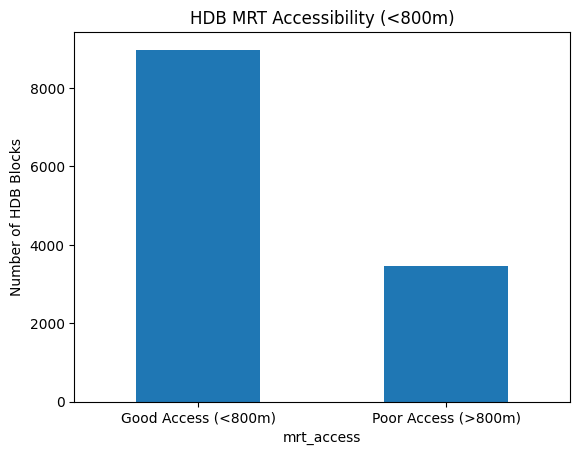

In [10]:
import matplotlib.pyplot as plt

hdb_coords['mrt_access'].value_counts().plot(kind='bar', title="HDB MRT Accessibility (<800m)")
plt.ylabel("Number of HDB Blocks")
plt.xticks(rotation=0)
plt.show()


In [11]:
# 1. Elderly population by planning area
elderly_clean = elderly_by_area.rename(columns={"Planning Area": "PLN_AREA_N"})

# 2. MRT accessibility summary by planning area
access_summary = hdb_coords.groupby(['PLN_AREA_N', 'mrt_access']).size().unstack().fillna(0)
access_summary['Total_HDB'] = access_summary.sum(axis=1)
access_summary['% Good Access (<800m)'] = (
    access_summary['Good Access (<800m)'] / access_summary['Total_HDB']
) * 100
access_summary = access_summary.reset_index()

# Normalize planning area names for both datasets
elderly_clean['PLN_AREA_N'] = elderly_clean['PLN_AREA_N'].str.strip().str.upper()
access_summary['PLN_AREA_N'] = access_summary['PLN_AREA_N'].str.strip().str.upper()

# Re-merge with cleaned names
merged_summary = pd.merge(elderly_clean, access_summary, on='PLN_AREA_N', how='left')

# Fill missing values with 0
merged_summary[['Good Access (<800m)', 'Poor Access (>800m)', 'Total_HDB', '% Good Access (<800m)']] = \
    merged_summary[['Good Access (<800m)', 'Poor Access (>800m)', 'Total_HDB', '% Good Access (<800m)']].fillna(0)

merged_summary = merged_summary[~(merged_summary['Total_HDB'] == 0)]

# Select relevant columns with correct names
planning_area_coords = hdb_coords[['PLN_AREA_N', 'lat', 'lng']].drop_duplicates()

# Group by planning area and take the first lat/lng as representative
planning_area_coords = planning_area_coords.groupby('PLN_AREA_N', as_index=False).first()

# Merge with the elderly + MRT access summary
planning_area_geo_summary = pd.merge(merged_summary, planning_area_coords, on='PLN_AREA_N', how='left')


planning_area_geo_summary.to_csv('elderly_transport_gap_analysis.csv', index=False)
access_summary



mrt_access,PLN_AREA_N,Good Access (<800m),Poor Access (>800m),Total_HDB,% Good Access (<800m)
0,ANG MO KIO,262.0,190.0,452.0,57.964602
1,BEDOK,485.0,143.0,628.0,77.229299
2,BISHAN,154.0,125.0,279.0,55.197133
3,BUKIT BATOK,305.0,198.0,503.0,60.636183
4,BUKIT MERAH,436.0,130.0,566.0,77.031802
5,BUKIT PANJANG,417.0,0.0,417.0,100.000000
6,BUKIT TIMAH,29.0,0.0,29.0,100.000000
7,CHANGI,0.0,8.0,8.0,0.000000
8,CHOA CHU KANG,556.0,83.0,639.0,87.010955
9,CLEMENTI,161.0,84.0,245.0,65.714286


### filter out the hdb locations having poor mrt access

In [12]:
# Filter only blocks with poor MRT access
hdb_poor_access = hdb_coords[hdb_coords['mrt_access'] == 'Poor Access (>800m)']

# add population info if merged earlier
hdb_poor_access.to_csv("hdb_blocks_poor_mrt_access.csv", index=False)


### Creating Multi-Layer Map Dataset for Power BI

**Rationale**:  
This code prepares a combined dataset to display both **HDB block locations** and their **nearest MRT stations** on the same map in Power BI. Since Power BI's default map visual only accepts one set of latitude/longitude coordinates, I create a unified table with a `location_type` column to distinguish between HDB and MRT markers. This enables multi-layer pin visualization for better spatial insights.


In [13]:
# Create a copy of HDB layer
hdb_layer = hdb_poor_access[['blk_no', 'PLN_AREA_N', 'lat', 'lng']]
hdb_layer['name'] = 'Block ' + hdb_layer['blk_no'].astype(str) + ' (' + hdb_layer['PLN_AREA_N'] + ')'
hdb_layer['location_type'] = 'HDB'
hdb_layer = hdb_layer[['name', 'lat', 'lng', 'location_type']]

# Create MRT layer
mrt_layer = hdb_poor_access[['nearest_mrt_name', 'nearest_mrt_lat', 'nearest_mrt_lng']].copy()
mrt_layer = mrt_layer.rename(columns={
    'nearest_mrt_name': 'name',
    'nearest_mrt_lat': 'lat',
    'nearest_mrt_lng': 'lng'
})
mrt_layer['location_type'] = 'MRT'

# Drop duplicate MRT stations (since each HDB row might repeat same MRT station)
# Round lat/lng to 2 decimal places to group near-identical MRT stations
mrt_layer['lat'] = mrt_layer['lat'].round(2)
mrt_layer['lng'] = mrt_layer['lng'].round(2)

# Then drop duplicates
mrt_layer = mrt_layer.drop_duplicates(subset=['name', 'lat', 'lng'])


# Combine both into a single table
combined_map_data = pd.concat([hdb_layer, mrt_layer], ignore_index=True)

# Save to CSV
combined_map_data.to_csv("hdb_mrt_map_layer.csv", index=False)

combined_map_data.head()


/tmp/ipython-input-1720479950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hdb_layer['name'] = 'Block ' + hdb_layer['blk_no'].astype(str) + ' (' + hdb_layer['PLN_AREA_N'] + ')'
/tmp/ipython-input-1720479950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hdb_layer['location_type'] = 'HDB'


,name,lat,lng,location_type
0,Block 1 (BEDOK),1.327969,103.922716,HDB
1,Block 1 (CHANGI),1.388610,103.988093,HDB
2,Block 1 (GEYLANG),1.311291,103.897703,HDB
3,Block 1 (BUKIT MERAH),1.286442,103.808287,HDB
4,Block 1 (MARINE PARADE),1.304829,103.918615,HDB


## Inspect the POI dataset

In [14]:
poi_info = poi_df.info()

poi_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8672 entries, 0 to 8671
Columns: 125 entries, Unnamed: 0 to REGION_C
dtypes: bool(105), float64(6), int64(1), object(13)
memory usage: 2.2+ MB


In [15]:
poi_df.columns.tolist()

['Unnamed: 0',
 'place_id',
 'name',
 'lat',
 'lng',
 'rating',
 'user_ratings_total',
 'price_level',
 'formatted_address',
 'global_code',
 'compound_code',
 'planning_area',
 'brand',
 'establishment',
 'point_of_interest',
 'store',
 'food',
 'health',
 'restaurant',
 'hospital',
 'lodging',
 'finance',
 'cafe',
 'convenience_store',
 'clothing_store',
 'atm',
 'shopping_mall',
 'grocery_or_supermarket',
 'home_goods_store',
 'school',
 'bakery',
 'beauty_salon',
 'transit_station',
 'place_of_worship',
 'pharmacy',
 'meal_takeaway',
 'furniture_store',
 'tourist_attraction',
 'secondary_school',
 'supermarket',
 'doctor',
 'shoe_store',
 'dentist',
 'jewelry_store',
 'church',
 'bank',
 'primary_school',
 'electronics_store',
 'gym',
 'spa',
 'car_repair',
 'pet_store',
 'bus_station',
 'university',
 'park',
 'general_contractor',
 'subway_station',
 'real_estate_agency',
 'florist',
 'hair_care',
 'department_store',
 'hardware_store',
 'car_dealer',
 'veterinary_care',
 'travel

## POI Dataset Cleaning & Categorization

The raw POI dataset contains many boolean columns instead of a single 'category' column.
Each row may represent multiple types of places (e.g., clinic, hospital, park, etc.).

We'll do the following:
1. Select only the POI types relevant to elderly accessibility: `clinic`, `hospital`, `pharmacy`, `doctor`, `dentist`, `park`, `hawker centre`
2. Create a new column called `category` based on the first match in priority order
3. Remove any rows where none of the above types are present

In [16]:
# Define relevant POI types in priority order
relevant_categories = [
    'clinic', 'hospital', 'pharmacy', 'doctor', 'dentist', 'health', 'park', 'hawker centre'
]

# Create a 'category' column based on first matching POI type
def assign_category(row):
    for cat in relevant_categories:
        if cat in row and row[cat] is True:
            return cat
    return None

poi_df['category'] = poi_df.apply(assign_category, axis=1)

# Drop rows with no matching elderly-relevant category
cleaned_poi_df = poi_df.dropna(subset=['category'])
cleaned_poi_df.to_csv('cleaned_poi_for_eldelry.csv', index=False)

cleaned_poi_df.head()

,Unnamed: 0,place_id,name,lat,lng,rating,user_ratings_total,price_level,formatted_address,global_code,...,natural_feature,subpremise,SUBZONE_NO,SUBZONE_N,SUBZONE_C,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,category
14,14,ChIJ58zgd34b2jERDEawXFNpWOE,NEWest,1.316485,103.757396,3.7,121.0,NaN,"1 W Coast Dr, Newest, Singapore 128021",6PH58Q84+HX,...,False,False,5.0,WEST COAST,CLSZ05,CLEMENTI,CL,WEST REGION,WR,health
168,168,ChIJ--0TQUUZ2jER-DI5Rk2cN30,Astute Medical Clinic,1.283716,103.846582,4.4,14.0,NaN,"18 Cross St, #01-112, Cross Street Exchange, S...",NaN,...,False,False,4.0,CHINA SQUARE,OTSZ04,OUTRAM,OT,CENTRAL REGION,CR,health
169,169,ChIJ-0W7K8kZ2jERTWFrd1AKRvw,First Aid Shop,1.312220,103.859553,0.0,0.0,NaN,"32 Sturdee Rd, Singapore 207853",6PH58V65+VR,...,False,False,6.0,LAVENDER,KLSZ06,KALLANG,KL,CENTRAL REGION,CR,hospital
170,170,ChIJ-1K48DEX2jERCjzlnzYN-I4,Aapage office,1.354100,103.827839,0.0,0.0,NaN,"2 Kallang Ave, CT Hub @ Kallang, Singapore 339407",6PH59R3H+J4,...,False,False,1.0,UPPER THOMSON,BSSZ01,BISHAN,BS,CENTRAL REGION,CR,hospital
171,171,ChIJ-3Rd52AX2jERNlG0QFJhPHE,DTAP Clinic @Kovan (Dr. Tan & Partners),1.361846,103.887201,5.0,2.0,NaN,"#01-21 988 Upper Serangoon Rd, Stars of Kovan,...",6PH59V6P+PV,...,False,False,7.0,LORONG AH SOO,HGSZ07,HOUGANG,HG,NORTH-EAST REGION,NER,hospital


In [17]:
# Filter out the dataset with relevant categories
filtered_poi_df = cleaned_poi_df[cleaned_poi_df['category'].isin(relevant_categories)]
filtered_poi_df = filtered_poi_df[['name', 'PLN_AREA_N', 'category', 'lat', 'lng']]

filtered_poi_health_hospital_df = filtered_poi_df[filtered_poi_df['category'].isin(['hospital', 'health'])]
filtered_poi_health_hospital_df

,name,PLN_AREA_N,category,lat,lng
14,NEWest,CLEMENTI,health,1.316485,103.757396
168,Astute Medical Clinic,OUTRAM,health,1.283716,103.846582
169,First Aid Shop,KALLANG,hospital,1.312220,103.859553
170,Aapage office,BISHAN,hospital,1.354100,103.827839
171,DTAP Clinic @Kovan (Dr. Tan & Partners),HOUGANG,hospital,1.361846,103.887201
...,...,...,...,...,...
7937,Venus Secret - Beauty & Wellness,OUTRAM,health,1.274863,103.842634
8182,Clinique - BHG Bugis,DOWNTOWN CORE,health,1.299806,103.856369
8186,Welcia BHG White Sands,PASIR RIS,health,1.372551,103.949387
8191,New York Skin Solutions - BHG Bishan,BISHAN,health,1.350403,103.848756


In [18]:
# Filter for Downtown Core planning area
downtown_healthcare_hospital_df = filtered_poi_health_hospital_df[
    filtered_poi_health_hospital_df['PLN_AREA_N'] == 'DOWNTOWN CORE'
]

# Display the filtered results
display(downtown_healthcare_hospital_df)


,name,PLN_AREA_N,category,lat,lng
183,Huaxia Acupuncture & Chinese Medical Centre,DOWNTOWN CORE,hospital,1.302119,103.864088
188,Singapore hospital,DOWNTOWN CORE,hospital,1.277737,103.847622
203,Bethesda Medical Centre,DOWNTOWN CORE,hospital,1.294602,103.857882
243,SBF Medical Suites,DOWNTOWN CORE,hospital,1.278027,103.847984
246,Raffles Executive Medical Centre,DOWNTOWN CORE,hospital,1.301349,103.857150
...,...,...,...,...,...
6057,Watsons,DOWNTOWN CORE,health,1.284264,103.852513
6061,Watsons Singapore - Amara 100AM (Click & Collect),DOWNTOWN CORE,health,1.274946,103.843409
6067,Watsons Singapore - Raffles City (Click & Coll...,DOWNTOWN CORE,health,1.293921,103.853389
6069,Watsons Singapore - Suntec City (Click & Collect),DOWNTOWN CORE,health,1.295711,103.858649


In [19]:
# Filter POIs and HDBs with valid coordinates
filtered_poi_health_hospital_df = filtered_poi_health_hospital_df.dropna(subset=['lat', 'lng']).copy()
poi_points = filtered_poi_health_hospital_df[['lat', 'lng']].to_numpy()

hdb_coords = hdb_coords.dropna(subset=['lat', 'lng']).copy()
hdb_points = hdb_coords[['lat', 'lng']].to_numpy()

# Fit NearestNeighbors model on HDB coordinates`
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn.fit(hdb_points)

# Calculate distances and assign to filtered POI DataFrame
distances, indices = knn.kneighbors(poi_points)
filtered_poi_health_hospital_df['nearest_hdb_dist_m'] = distances.flatten() * 111139

# Classify accessibility
filtered_poi_health_hospital_df['hdb_access'] = filtered_poi_health_hospital_df['nearest_hdb_dist_m'].apply(
    lambda d: 'Accessible (<500m)' if d <= 500 else 'Inaccessible (>500m)'
)

# Group by planning area and summarize accessibility
summary_filtered_poi_health_hospital_df = filtered_poi_health_hospital_df.groupby('PLN_AREA_N')['hdb_access'].value_counts().unstack().fillna(0)
summary_filtered_poi_health_hospital_df['Total_HospitalHealthCare'] = summary_filtered_poi_health_hospital_df.sum(axis=1)
summary_filtered_poi_health_hospital_df['% Accessible'] = (summary_filtered_poi_health_hospital_df['Accessible (<500m)'] / summary_filtered_poi_health_hospital_df['Total_HospitalHealthCare']) * 100

location_summary = filtered_poi_health_hospital_df.groupby('PLN_AREA_N').agg({
    'lat': 'mean',
    'lng': 'mean'
}).reset_index()

location_summary.to_csv('location_healthcare_hospital_summary.csv', index=False)
summary_filtered_poi_health_hospital_df.to_csv('healthcare_hospital_summary.csv', index=False)




Preparing Data for Dashboarding(Dentist and Pharmacy)

In [20]:
#Preparing Data for Dashboarding(Pharmacy and Dentist)
import pandas as pd

# Load the datasets
poi_df = pd.read_csv('cleaned_poi_for_eldelry.csv')
hdb_mrt_df = pd.read_csv('hdb_mrt_map_layer.csv')

# Show the first few rows of both to understand the structure
poi_df.head(), hdb_mrt_df.head()


(   Unnamed: 0                     place_id  \
 0          14  ChIJ58zgd34b2jERDEawXFNpWOE   
 1         168  ChIJ--0TQUUZ2jER-DI5Rk2cN30   
 2         169  ChIJ-0W7K8kZ2jERTWFrd1AKRvw   
 3         170  ChIJ-1K48DEX2jERCjzlnzYN-I4   
 4         171  ChIJ-3Rd52AX2jERNlG0QFJhPHE   
 
                                       name       lat         lng  rating  \
 0                                   NEWest  1.316485  103.757396     3.7   
 1                    Astute Medical Clinic  1.283716  103.846582     4.4   
 2                           First Aid Shop  1.312220  103.859553     0.0   
 3                            Aapage office  1.354100  103.827839     0.0   
 4  DTAP Clinic @Kovan (Dr. Tan & Partners)  1.361846  103.887201     5.0   
 
    user_ratings_total  price_level  \
 0               121.0          NaN   
 1                14.0          NaN   
 2                 0.0          NaN   
 3                 0.0          NaN   
 4                 2.0          NaN   
 
                

In [21]:
# Unique categories in POI data
unique_categories = poi_df['category'].unique()

# Sample some names and categories to identify dentists and pharmacies
poi_sample = poi_df[['name', 'category']].sample(10, random_state=1)

unique_categories, poi_sample


(array(['health', 'hospital', 'pharmacy', 'dentist', 'doctor', 'park'],
       dtype=object),
                                                   name  category
 920             Valerie Physiotherapy Centre Pte. Ltd.    health
 817                             Iron Fitness Singapore    health
 443                                       Fones Clinic  hospital
 701  Dr Jeeve - The ENT Clinic @ Mt Elizabeth Noven...    doctor
 108                        One North Meditation Spaces  hospital
 971                          Sembawang Hot Spring Park      park
 65                               ZENITH MEDICAL CLINIC  hospital
 866                      Ng Teng Fong General Hospital  hospital
 853  Women Fertility & Fetal Centre: Dr Ann Tan - F...  hospital
 556                               Buangkok Sports Park      park)

In [22]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Filter POIs for dentists and pharmacies only
poi_filtered = poi_df[poi_df['category'].isin(['dentist', 'pharmacy'])].reset_index(drop=True)

# Extract coordinates for dentists and pharmacies
dentist_coords = poi_filtered[poi_filtered['category'] == 'dentist'][['lat', 'lng']].to_numpy()
pharmacy_coords = poi_filtered[poi_filtered['category'] == 'pharmacy'][['lat', 'lng']].to_numpy()

# Extract HDB coordinates
hdb_coords = hdb_mrt_df[hdb_mrt_df['location_type'] == 'HDB'][['lat', 'lng']].to_numpy()

# Function to get distances to k nearest POIs
def knn_distances(hdb_points, poi_points, k=3):
    if len(poi_points) == 0:
        # If no POIs available for that category, return large distances
        return np.full((len(hdb_points), k), np.inf)

    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(poi_points)
    distances, _ = knn.kneighbors(hdb_points)
    return distances

# Calculate distances to nearest 3 dentists and pharmacies from each HDB
dist_dentists = knn_distances(hdb_coords, dentist_coords, k=3)
dist_pharmacies = knn_distances(hdb_coords, pharmacy_coords, k=3)

dist_dentists[:5], dist_pharmacies[:5]


(array([[0.00274029, 0.00288005, 0.01014488],
        [0.03562329, 0.04369492, 0.05761975],
        [0.00350057, 0.0045157 , 0.00530316],
        [0.00300236, 0.00848736, 0.00908558],
        [0.00363523, 0.00750219, 0.01306281]]),
 array([[0.00736661, 0.00755014, 0.00952333],
        [0.0319837 , 0.03338978, 0.04143358],
        [0.00790817, 0.00808156, 0.00861192],
        [0.00993835, 0.0185165 , 0.02411603],
        [0.00890343, 0.01344333, 0.01355556]]))

In [23]:
# Small epsilon to avoid division by zero
epsilon = 1e-6

# Average distance to nearest 3 dentists and pharmacies for each HDB
avg_dist_dentists = dist_dentists.mean(axis=1)
avg_dist_pharmacies = dist_pharmacies.mean(axis=1)

# Accessibility metric: average of inverse distances
accessibility_metric = 0.5 * (1 / (avg_dist_dentists + epsilon) + 1 / (avg_dist_pharmacies + epsilon))

# Attach the metric back to the HDB dataframe
hdb_mrt_df_filtered = hdb_mrt_df[hdb_mrt_df['location_type'] == 'HDB'].copy()
hdb_mrt_df_filtered['accessibility_metric'] = accessibility_metric

# Show top 5 with metric
hdb_mrt_df_filtered.head()

,name,lat,lng,location_type,accessibility_metric
0,Block 1 (BEDOK),1.327969,103.922716,HDB,156.495155
1,Block 1 (CHANGI),1.388610,103.988093,HDB,24.997248
2,Block 1 (GEYLANG),1.311291,103.897703,HDB,173.556146
3,Block 1 (BUKIT MERAH),1.286442,103.808287,HDB,101.423584
4,Block 1 (MARINE PARADE),1.304829,103.918615,HDB,103.751750


In [24]:
# Calculate the 33rd and 66th percentiles
p33, p66 = np.percentile(hdb_mrt_df_filtered['accessibility_metric'], [33, 66])

# Define bins and labels
bins = [-float('inf'), p33, p66, float('inf')]
labels = ['Poor Accessibility', 'Moderate Accessibility', 'High Accessibility']

# Create category column
hdb_mrt_df_filtered['accessibility_category'] = pd.cut(
    hdb_mrt_df_filtered['accessibility_metric'],
    bins=bins,
    labels=labels
)

# Create numeric code for sorting in Power BI
category_order = {
    'Poor Accessibility': 3,
    'Moderate Accessibility': 2,
    'High Accessibility': 1
}
hdb_mrt_df_filtered['accessibility_code'] = hdb_mrt_df_filtered['accessibility_category'].map(category_order)

# Optional: round metric for cleaner display in tooltips
hdb_mrt_df_filtered['accessibility_metric'] = hdb_mrt_df_filtered['accessibility_metric'].round(4)

# Show breakpoints for reference
print(f"33rd percentile: {p33:.4f}, 66th percentile: {p66:.4f}")

# Extract text inside parentheses
hdb_mrt_df_filtered['region'] = hdb_mrt_df_filtered['name'].str.extract(r'\((.*?)\)')

# Save to CSV in runtime
hdb_mrt_df_filtered.to_csv('hdb_mrt_df_filtered.csv', index=False)

# Preview
hdb_mrt_df_filtered.head()

33rd percentile: 73.6190, 66th percentile: 91.3260


,name,lat,lng,location_type,accessibility_metric,accessibility_category,accessibility_code,region
0,Block 1 (BEDOK),1.327969,103.922716,HDB,156.4952,High Accessibility,1,BEDOK
1,Block 1 (CHANGI),1.388610,103.988093,HDB,24.9972,Poor Accessibility,3,CHANGI
2,Block 1 (GEYLANG),1.311291,103.897703,HDB,173.5561,High Accessibility,1,GEYLANG
3,Block 1 (BUKIT MERAH),1.286442,103.808287,HDB,101.4236,High Accessibility,1,BUKIT MERAH
4,Block 1 (MARINE PARADE),1.304829,103.918615,HDB,103.7518,High Accessibility,1,MARINE PARADE


Access of Dentist and Pharmacies from MRT Stations

In [25]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Load data
poi_df = pd.read_csv('cleaned_poi_for_eldelry.csv')
hdb_mrt_df = pd.read_csv('hdb_mrt_map_layer.csv')

# Extract MRT coordinates
mrt_coords = hdb_mrt_df[hdb_mrt_df['location_type'] == 'MRT'][['name', 'lat', 'lng']].dropna()
mrt_coords_array = mrt_coords[['lat', 'lng']].to_numpy()

# Filter only pharmacies and dentists
poi_filtered = poi_df[poi_df['category'].isin(['pharmacy', 'dentist'])].dropna(subset=['lat', 'lng']).reset_index(drop=True)
poi_coords_array = poi_filtered[['lat', 'lng']].to_numpy()

# Fit KNN on MRT coordinates
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn.fit(mrt_coords_array)

# Find nearest MRT for each POI
distances, indices = knn.kneighbors(poi_coords_array)

# Convert degrees to meters
meters = distances * 111_139  # approx

# Attach nearest MRT info
nearest_mrts = mrt_coords.iloc[indices.flatten()].reset_index(drop=True)

poi_filtered['nearest_mrt_name'] = nearest_mrts['name']
poi_filtered['nearest_mrt_lat'] = nearest_mrts['lat']
poi_filtered['nearest_mrt_lng'] = nearest_mrts['lng']
poi_filtered['min_dist_mrt_m'] = meters.flatten()

# Classify access
poi_filtered['mrt_access'] = poi_filtered['min_dist_mrt_m'].apply(
    lambda x: "Good Access (<500m)" if x <= 500 else "Poor Access (>500m)"
)

# Summary count
print(poi_filtered.groupby(['category', 'mrt_access']).size())

# Save results
poi_filtered.to_csv('poi_mrt_accessibility.csv', index=False)


category  mrt_access         
dentist   Good Access (<500m)     26
          Poor Access (>500m)     83
pharmacy  Good Access (<500m)     64
          Poor Access (>500m)    116
dtype: int64


In [26]:
# 1. MRT accessibility summary for pharmacies & dentists by planning area
access_summary = poi_filtered.groupby(['PLN_AREA_N', 'mrt_access']).size().unstack().fillna(0)
access_summary['Total_POI'] = access_summary.sum(axis=1)
access_summary['% Good Access (<500m)'] = (
    access_summary['Good Access (<500m)'] / access_summary['Total_POI']
) * 100
access_summary = access_summary.reset_index()

# 2. Representative coordinates per planning area
planning_area_coords = poi_filtered[['PLN_AREA_N', 'lat', 'lng']].drop_duplicates()
planning_area_coords = planning_area_coords.groupby('PLN_AREA_N', as_index=False).first()

# 3. Merge coordinates into summary
planning_area_geo_summary = pd.merge(access_summary, planning_area_coords, on='PLN_AREA_N', how='left')

# 4. Rename PLN_AREA_N into region
planning_area_geo_summary.rename(columns={'PLN_AREA_N': 'Region'}, inplace=True)

planning_area_geo_summary.to_csv('healthcare_accessibility_by_area.csv', index=False)

planning_area_geo_summary.head()

,Region,Good Access (<500m),Poor Access (>500m),Total_POI,% Good Access (<500m),lat,lng
0,ANG MO KIO,3.0,3.0,6.0,50.000000,1.372790,103.846467
1,BEDOK,1.0,14.0,15.0,6.666667,1.334560,103.900805
2,BISHAN,5.0,3.0,8.0,62.500000,1.349259,103.849001
3,BOON LAY,0.0,1.0,1.0,0.000000,1.319068,103.713948
4,BUKIT BATOK,2.0,1.0,3.0,66.666667,1.350055,103.749808


In [27]:

# Extract MRT coordinates
mrt_coords = hdb_mrt_df[hdb_mrt_df['location_type'] == 'MRT'][['name', 'lat', 'lng']].dropna()
mrt_coords_array = mrt_coords[['lat', 'lng']].to_numpy()

# Filter only pharmacies and dentists
poi_filtered = poi_df[poi_df['category'].isin(['pharmacy', 'dentist'])].dropna(subset=['lat', 'lng']).reset_index(drop=True)
poi_coords_array = poi_filtered[['lat', 'lng']].to_numpy()

# Fit KNN on MRT coordinates
knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn.fit(mrt_coords_array)

# Find nearest MRT for each POI
distances, indices = knn.kneighbors(poi_coords_array)

# Convert degrees to meters (approximate)
dist_meters = distances * 111_139

# Attach nearest MRT info
nearest_mrts = mrt_coords.iloc[indices.flatten()].reset_index(drop=True)

poi_filtered['nearest_mrt_name'] = nearest_mrts['name']
poi_filtered['nearest_mrt_lat'] = nearest_mrts['lat']
poi_filtered['nearest_mrt_lng'] = nearest_mrts['lng']
poi_filtered['distance_from_nearest_mrt_m'] = dist_meters.flatten()

# Classify access based on distance
poi_filtered['mrt_access'] = poi_filtered['distance_from_nearest_mrt_m'].apply(
    lambda x: "Good" if x <= 500 else "Poor"
)

# Save results to a uniquely named CSV file
poi_filtered.to_csv('pharmacy_dentist_mrt_distances.csv', index=False)

poi_filtered.head()

,Unnamed: 0,place_id,name,lat,lng,rating,user_ratings_total,price_level,formatted_address,global_code,...,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,category,nearest_mrt_name,nearest_mrt_lat,nearest_mrt_lng,distance_from_nearest_mrt_m,mrt_access
0,218,ChIJ4QCjoNUT2jERvY7xXjWsqyg,Admiralty Medical Centre (AdMC) Pharmacy Services,1.439895,103.800619,0.0,0.0,NaN,"676 Woodlands Drive 71, #03-01, Singapore 730676",6PH5CRQ2+RC,...,WOODLANDS,WD,NORTH REGION,NR,pharmacy,ADMIRALTY MRT STATION,1.44,103.80,69.750285,Good
1,1402,ChIJh1x1PRQX2jERU-fT2FcmcBs,Junction 8 Dental Surgery,1.349259,103.849001,2.0,4.0,NaN,"506 Bishan Street 11, Singapore",6PH58RXX+PJ,...,BISHAN,BS,CENTRAL REGION,CR,dentist,BISHAN MRT STATION,1.35,103.85,138.192299,Good
2,1403,ChIJ1Q2rA5MZ2jER_Rz6dQj86wg,The Oral Maxillofacial Practice,1.322024,103.844301,4.6,12.0,NaN,"38 Irrawaddy Road, Mount Elizabeth Novena Spec...",6PH58RCV+RP,...,NOVENA,NV,CENTRAL REGION,CR,dentist,TOA PAYOH MRT STATION,1.33,103.85,1089.459524,Poor
3,1404,ChIJPYOBUv082jERVM4c18ofvSM,Neptune Dental Group Tampines,1.354001,103.961420,4.5,29.0,NaN,"357 Tampines Street 33, #01-610, Singapore",6PH59X36+JH,...,TAMPINES,TM,EAST REGION,ER,dentist,TAMPINES MRT STATION,1.35,103.95,1344.886316,Poor
4,1405,ChIJBwAAMPAX2jER4HLwDP3WZa0,Schlegel Pty. Ltd.,1.334560,103.900805,0.0,0.0,NaN,"9 Kaki Bukit Rd 1, Singapore",6PH58WM2+R8,...,BEDOK,BD,EAST REGION,ER,dentist,KAKI BUKIT MRT STATION,1.33,103.91,1140.671943,Poor
